### This notebook implements :
1. Squeezing input curve on 350 nm to 5 values.
2. KAN fitting on data of 4 component task with squeezed input data.
3. Visualization KAN learning and results.
4. KAN with early stopping.

In [1]:
# pip install pykan

import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

from tqdm import tqdm

In [10]:
currentdir = os.path.abspath("")
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from KAN_sourse import KAN_es

## Loading data

In [32]:
def load_map(n_file, spec_file):
    """Loads 2D fluorescence map and returns as df.
    """
    df = pd.read_csv(spec_file + f'/{n_file}' + '.csv', index_col=0).iloc[1:, :-1].T

    # function for renaming labels and indexes in map
    vec_renaming = lambda vec_list: [float(name.split()[0]) for name in vec_list]

    df.columns = vec_renaming(df.columns)
    df.index = vec_renaming(df.index)

    return df


def get_wavelength(spec_file, n_file=1):
    """Loads array of wavelength.
    """
    df = pd.read_csv(spec_file + f'/{n_file}' + '.csv', index_col=0).iloc[1:, :-1].T

    # function for renaming labels and indexes in map
    vec_renaming = lambda vec_list: [float(name.split()[0]) for name in vec_list]

    l_wavelenth = np.array(vec_renaming(df.columns))

    return l_wavelenth


def get_x(wave_length, spec_file):
    """Forms and returns data of fluorescence - x data.
    """
    l_X = []
    for n_file in range(1, 1001):
        fl_map = load_map(n_file, spec_file)
        l_X.append(fl_map.loc[wave_length])
    X = pd.DataFrame(l_X, index = np.arange(1,1001), dtype=np.float64)

    return X


def get_y(l_ions, spec_file):
    """Forms and returns data of ions concentration - y data.
    """
    df = pd.read_excel(spec_file + f'/Y_answers.xlsx', index_col=0)

    y = df[l_ions].to_numpy(dtype=np.float64).ravel()

    return y

In [33]:
EXCITE_WAVE_LENGTH = 350
PREDICT_IONS = ['Cr']
SPEC_FOLDER = 'full_data'

TRAIN_TEST_RATIO = 0.9
VALIDATION_TRAIN_RATIO = 0.222
N_ITER_NO_CHANGE = 10

In [34]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [35]:
x

,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,...,741.0,742.0,743.0,744.0,745.0,746.0,747.0,748.0,749.0,750.0
1,2.358,2.249,0.788,2.067,2.199,0.732,1.025,1.716,1.537,0.052,...,2.829,2.543,2.694,3.451,2.910,3.381,3.153,2.326,3.439,3.443
2,5.769,3.680,4.350,5.620,3.090,4.872,3.121,4.202,3.247,2.855,...,3.710,6.719,4.194,4.926,5.587,4.855,5.233,5.584,6.135,7.171
3,2.037,1.928,2.309,2.725,1.803,1.677,1.977,1.857,2.106,1.375,...,3.709,4.711,4.647,5.305,5.232,5.473,5.337,2.666,4.993,3.228
4,3.075,2.551,1.681,1.908,2.565,2.419,2.323,2.013,1.767,2.648,...,5.002,4.668,3.596,4.468,2.947,5.330,3.648,4.799,4.234,4.523
5,1.423,2.238,2.101,2.561,1.994,1.808,1.691,1.662,2.191,1.002,...,5.019,3.541,4.198,5.146,5.086,4.007,5.724,5.749,3.717,4.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.932,2.551,2.051,2.668,1.659,2.705,2.637,1.642,2.294,2.138,...,4.665,3.308,3.899,2.836,3.634,3.602,4.800,4.638,3.036,5.293
997,4.008,3.593,2.359,2.731,2.395,2.859,1.878,2.170,2.887,0.898,...,3.452,4.428,3.616,4.664,4.877,4.359,5.153,3.957,4.406,4.507
998,3.214,2.987,3.374,3.145,2.788,2.231,2.414,1.673,2.372,2.171,...,3.111,3.621,3.163,3.341,4.779,3.578,6.185,3.565,4.193,4.088
999,3.257,2.987,3.121,3.626,1.442,3.501,1.814,2.174,1.252,1.788,...,3.904,3.065,3.455,3.551,3.164,4.492,4.171,3.796,5.633,4.440


In [36]:
y

array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65,
       2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 ,
       2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75,
       3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 ,
       3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85,
       4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 ,
       4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95,
       0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.

# Squeeze input data

In [37]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

## Creating new inputs
As squeezed input data we will use:
1. $I$: Maximum intensity value 
2. $c$: Position of maximum intensity
3. $c_h$ : Center position intensity curve on I/2 intensity
4. $wth$ : Width of intensity curve on I/2 intensity
5. $rat$ : Ratio of area under intensity curve on the right from c and on the left from

## Входные данные

1. $I$: Максимальная интенсивность
2. $c$: Координата максимума
3. $c_h$ : Положения отрезка на полувысоте пика
4. $wth$ : Ширина пика на полувысоте
5. $rat$ : Отношение площадей левого и правого крыла пика

In [38]:
def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

In [39]:
def get_all_sqz_input(matr_x, matr_y):
    ''' Evaluate squeezed data from all data.
    '''
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

In [40]:
x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()

x = get_all_sqz_input(x_matrix, y_matrix)

## Scaling data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Train+Validation) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / (Train+Validation)

In [41]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

In [42]:
x_train.shape, x_test.shape

((900, 5), (100, 5))

In [43]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## KAN

New ML architecture, alternative to neural networks. Relies on the Kolmagprov-Arnold theorem about decomposition of function with many parameters:
$$ f(x_{1},\cdot\cdot\cdot, x_{n})\sum_{q=1}^{2n+1}\Phi_{q}(\sum_{p=1}^{n}\varphi_{q,p}(x_{p})) $$

The main idea - represent $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ as a B-splines, and optimize their parameters during training.
After training it is possible to fit $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ by analytic formulas, post-train and express received KAN model as regular expression with analytic functions.


Some hyperparameteres of KANs (not all):
- grid: Number of grid intervals. 

Each function in KAN is represented in B-splines - in other words sum of polynoms, located on certain area of input parametere. Grid defines number of training parameteres and complexity of model. Number of grids can be gradually increased during training KAN - provided in "Gradially increasing grid" section.

- k: Order of piecewise polynomial in B-splines. k=3 provides smooth small order polynoms.

### Getting dataset for learning KAN in torch-representation

In [44]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

### Learning KAN

In [54]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
GRID = 1 # number of basic functions
HIDDEN_NEURONS = 1
LAMBDA = 0 # regularization learning coefficient
INPUT_SHAPE = tc_x_test.shape[1]

VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':False }

In [55]:
model = KAN(width=[INPUT_SHAPE, HIDDEN_NEURONS, 1], grid=GRID, k=K)

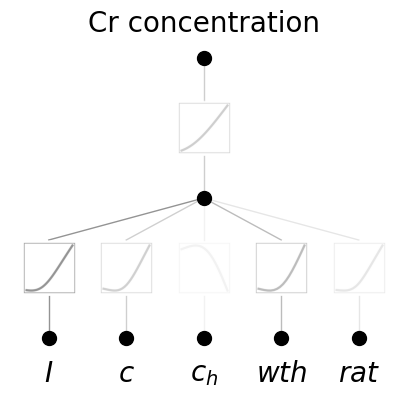

In [56]:
model(tc_x_train)
model.plot(**prnt_kwrgs)

In [29]:
result = model.train(dataset, opt="LBFGS", steps=20, 
                       lamb=LAMBDA,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

train loss: 3.50e-01 | test loss: 3.19e-01 | reg: 7.42e+00 : 100%|██| 20/20 [00:09<00:00,  2.16it/s]


### Plotting learning history

Text(0.5, 0, 'step')

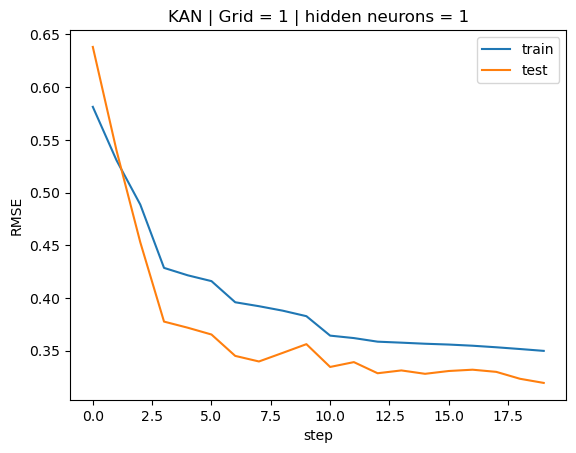

In [31]:
plt.plot(result['train_loss'])
plt.plot(result['test_loss'])
#plt.plot(result1['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title(f'KAN | Grid = {GRID} | hidden neurons = {HIDDEN_NEURONS}')
plt.ylabel('RMSE')
plt.xlabel('step')

### Plotting scatter prediction

In [32]:
def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

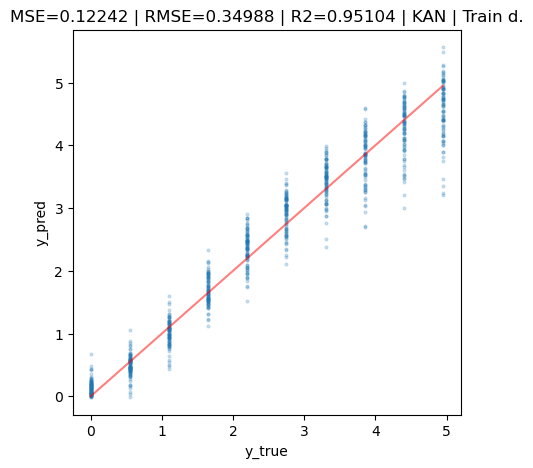

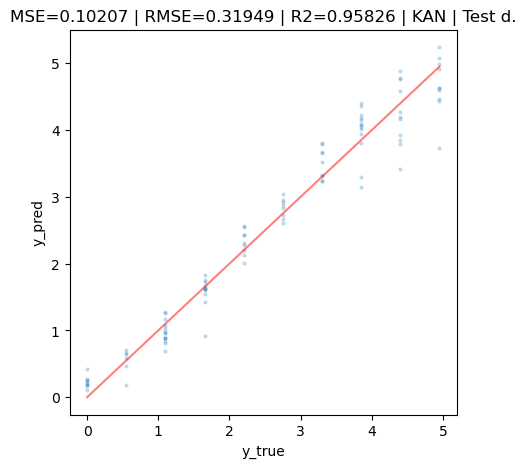

(0.10207071415949975, 0.9582623511378512)

In [33]:
scatter_prediction_kan(model, tc_x_train, tc_y_train, f"KAN | Train d.")
scatter_prediction_kan(model, tc_x_test, tc_y_test, f"KAN | Test d.")

### Some visualisations

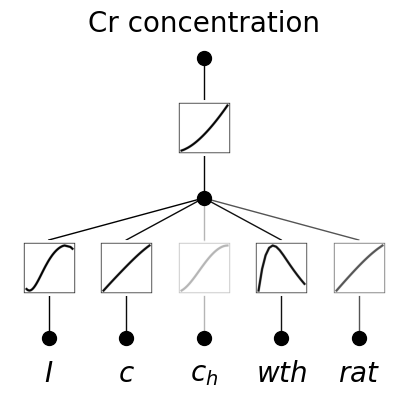

In [35]:
model.plot(**prnt_kwrgs)

### Prunning

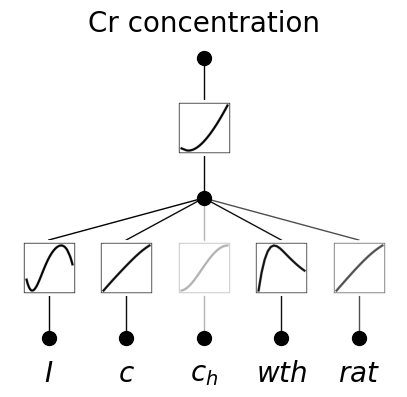

In [36]:
model_sym = model.prune() # Prunning

model_sym(dataset['train_input']) # it's important to do a forward first to collect activations
model_sym.plot(**prnt_kwrgs)

### Autosymbolic regression

In [37]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
model_sym.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
# lib = ['sin', 'x^2', 'exp']
# model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9956980921768481
fixing (0,1,0) with sin, r2=0.999975553693229
fixing (0,2,0) with sin, r2=0.9999601670903036
fixing (0,3,0) with sin, r2=0.808573446835507
fixing (0,4,0) with sin, r2=0.999996410538194
fixing (1,0,0) with gaussian, r2=0.9999544321915174


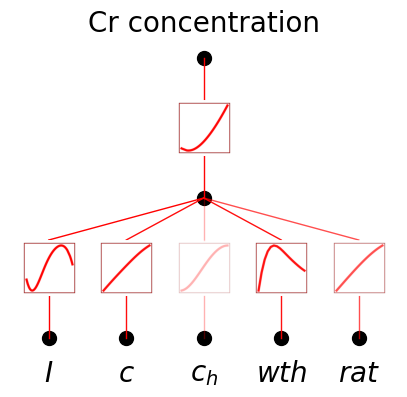

In [39]:
model_sym.plot(**prnt_kwrgs)

### Additional fitting for symbolised activations

train loss: 3.63e-01 | test loss: 3.31e-01 | reg: 8.43e+00 : 100%|██| 20/20 [00:05<00:00,  3.54it/s]


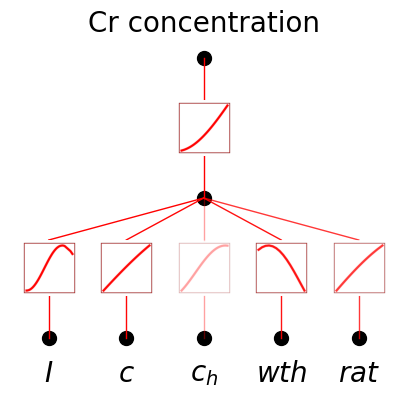

In [41]:
IMG_FOLDER_add='video_1'

model_sym.train(dataset, opt="LBFGS", steps=20, 
                              save_fig=True,
                              in_vars=VAR,
                              out_vars=[PREDICT_IONS[0] + ' concentration'],
                              img_folder=IMG_FOLDER_add)
model_sym.plot(**prnt_kwrgs)

In [40]:
# obtaining symbolic formula
formula, variables  = model_sym.symbolic_formula(var=['I', 'c', 'c_h', 'wth', 'rat'])
formula[0]

15.36 - 15.39*exp(-2.6*(0.11*sin(0.91*I + 9.25) - sin(0.2*c + 6.59) + 0.06*sin(0.71*c_h - 9.19) + 0.57*sin(0.21*rat + 9.79) - 0.01*sin(1.32*wth + 2.16) + 0.24)**2)

# KAN_es: KAN with early stopping

In [15]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, 
                                                  train_size=VALIDATION_TRAIN_RATIO, 
                                                  random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_val = torch.from_numpy(x_val)
tc_y_val = torch.from_numpy(y_val).reshape([-1,1])
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset_3 = {'train_input': tc_x_train,
             'train_label': tc_y_train,
             'val_input': tc_x_val,
             'val_label': tc_y_val,
             'test_input': tc_x_test,
             'test_label': tc_y_test}

In [16]:
tc_x_train.shape, tc_x_val.shape, tc_x_test.shape

(torch.Size([701, 5]), torch.Size([199, 5]), torch.Size([100, 5]))

In [17]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

trn_ls: 3.34e-01 | vl_ls: 3.55e-01 | e_stop: 10/10 | tst_ls: 3.23e-01 | reg: 1.56e+01 :  34%|█▎  | 67/200 [00:22<00:44,  2.97it/s]

Early stopping criteria raised


Text(0.5, 0, 'step')

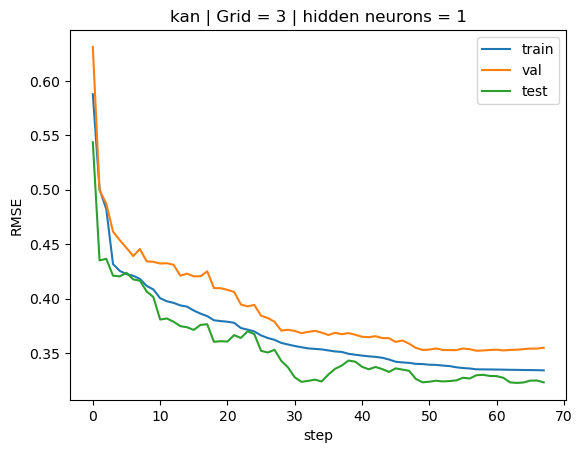

In [20]:
model_es = KAN_es(width=[INPUT_SHAPE, HIDDEN_NEURONS, 1], grid=GRID, k=K)

result_es = model_es.train_es(dataset_3, 
                              tol=0.0001, 
                              n_iter_no_change=10,
                              opt="LBFGS", steps=200, 
                              lamb=LAMBDA,
                              lamb_l1=1,
                              lamb_entropy=2
                              )

plt.plot(result_es['train_loss'])
plt.plot(result_es['val_loss'])
plt.plot(result_es['test_loss'])

#plt.plot(result1['reg'])
plt.legend(['train', 'val',  'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

### Making video

trn_ls: 3.37e-01 | vl_ls: 3.53e-01 | e_stop: 10/10 | tst_ls: 3.27e-01 | reg: 1.83e+01 :  42%|█▋  | 85/200 [02:04<02:48,  1.47s/it]

Early stopping criteria raised


Text(0.5, 0, 'step')

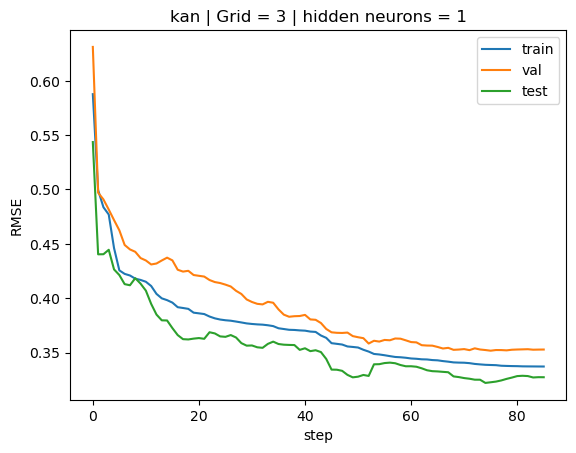

In [57]:
IMG_FOLDER='video'

model_es = KAN_es(width=[INPUT_SHAPE, HIDDEN_NEURONS, 1], grid=GRID, k=K)

result_es = model_es.train_es(dataset_3, 
                              tol=0.0001, 
                              n_iter_no_change=10,
                              opt="LBFGS", steps=200, 
                              lamb=LAMBDA,
                              lamb_l1=1,
                              lamb_entropy=2,
                              save_fig=True,
                              in_vars=VAR,
                              out_vars=[PREDICT_IONS[0] + ' concentration'],
                              img_folder=IMG_FOLDER)

plt.plot(result_es['train_loss'])
plt.plot(result_es['val_loss'])
plt.plot(result_es['test_loss'])

#plt.plot(result1['reg'])
plt.legend(['train', 'val',  'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

In [58]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip # moviepy == 1.0.3

IMG_FOLDER='video'

video_name=IMG_FOLDER
fps=5

fps = fps
files = os.listdir(IMG_FOLDER)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [IMG_FOLDER+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


fixing (0,0,0) with gaussian, r2=0.9968467937725178
fixing (0,1,0) with sqrt, r2=0.9999920741041307
fixing (0,2,0) with gaussian, r2=0.999622869634593
fixing (0,3,0) with gaussian, r2=0.9999974850420514
fixing (0,4,0) with tan, r2=0.9999330906078646
fixing (1,0,0) with sigmoid, r2=0.9999780919017467


trn_ls: 3.45e-01 | vl_ls: 3.64e-01 | e_stop: 10/10 | tst_ls: 3.30e-01 | reg: 1.90e+01 :  50%|██▌  | 10/20 [00:18<00:18,  1.83s/it]

Early stopping criteria raised


12.99 - 14.32*sigmoid(-16.39*sqrt(0.15*c + 1) - 5.67*tan(0.1*rat - 0.39) + 14.99 + 1.24*exp(-0.57*(-0.8*I - 1)**2) + 0.33*exp(-0.39*(1 - 0.34*wth)**2) - 1.13*exp(-0.17*(1 - 0.62*c_h)**2))

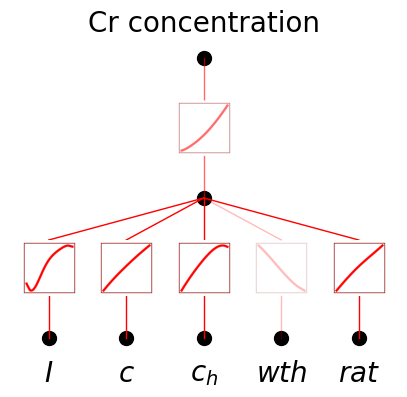

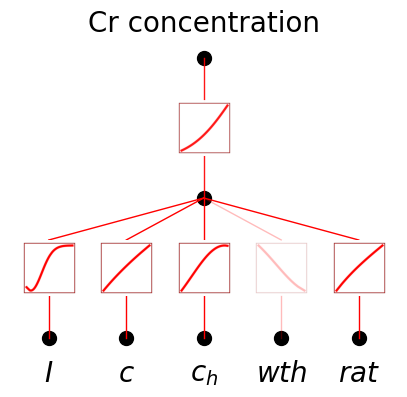

In [59]:
IMG_FOLDER_1 = 'video_1'

model_es.auto_symbolic()

model_es.plot(**prnt_kwrgs)

model_es.train_es(dataset_3,tol=0.001, n_iter_no_change=10, opt="LBFGS", steps=20,
                              save_fig=True,
                              in_vars=VAR,
                              out_vars=[PREDICT_IONS[0] + ' concentration'],
                              img_folder=IMG_FOLDER_1)
model_es.plot(**prnt_kwrgs)

# obtaining symbolic formula
formula, variables  = model_es.symbolic_formula(var=['I', 'c', 'c_h', 'wth', 'rat'])
formula[0]

In [60]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip # moviepy == 1.0.3

video_name=IMG_FOLDER_1
fps=5

fps = fps
files = os.listdir(IMG_FOLDER_1)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [IMG_FOLDER_1+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video_1.mp4.
Moviepy - Writing video video_1.mp4



Moviepy - Done !
Moviepy - video ready video_1.mp4
